In [1]:
from utils import *
from opt import *
import pandas as pd

(CVXPY) May 01 02:57:18 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) May 01 02:57:18 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) May 01 02:57:18 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')


In [2]:
senate_number = 110
members = pd.read_csv(f'senate data/S{str(senate_number).zfill(3)}_members.csv')
parties = pd.read_csv(f'senate data/S{str(senate_number).zfill(3)}_parties.csv')
rollcalls = pd.read_csv(f'senate data/S{str(senate_number).zfill(3)}_rollcalls.csv')
votes = pd.read_csv(f'senate data/S{str(senate_number).zfill(3)}_votes.csv')

num_votes = rollcalls.shape[0]

# members['state_icpsr'].nunique()
party_code = np.array(members['party_code'])
state_icpsr = np.array(members['state_icpsr'])
icpsr = np.array(members['icpsr'])

icpsr_to_party = dict(zip(icpsr,party_code))
icpsr_to_state = dict(zip(icpsr,state_icpsr))
castcode_to_vote = { 9:0, 7:0, 1:1, 6:-1 }
def party_to_color(code):
    if code==100:
        return 0
    elif code==200:
        return 1
    else:
        return 2

votes_per_rollcall = [votes.groupby('rollnumber').get_group(i_vote+1) for i_vote in range(num_votes)]


In [3]:
state_list = []
votes_list = []
nodes = []
for i_vote in range(num_votes):
    mat = np.array(votes_per_rollcall[i_vote][['icpsr','cast_code']])
    states_curr = np.array(list(map(lambda x:icpsr_to_state[x],mat[:,0])))
    votes_curr = np.array(list(map(lambda x:castcode_to_vote[x],mat[:,1])))
    parties_curr = np.array(list(map(lambda x:icpsr_to_party[x],mat[:,0])))

    state_inds = [np.where(states_curr==s)[0] for s in np.unique(states_curr)]

    state_list.append( np.unique(states_curr) )
    votes_list.append( np.array([np.mean(votes_curr[s_inds]) for s_inds in state_inds]) )
    nodes.append( list( map( party_to_color, np.array([np.mean(parties_curr[s_inds]) for s_inds in state_inds]) ) ) )


Beta: 1.0000e+02
Beta: 4.6416e+02
Beta: 2.1544e+03
Beta: 1.0000e+04
Beta: 4.6416e+04
Beta: 2.1544e+05
Beta: 1.0000e+06


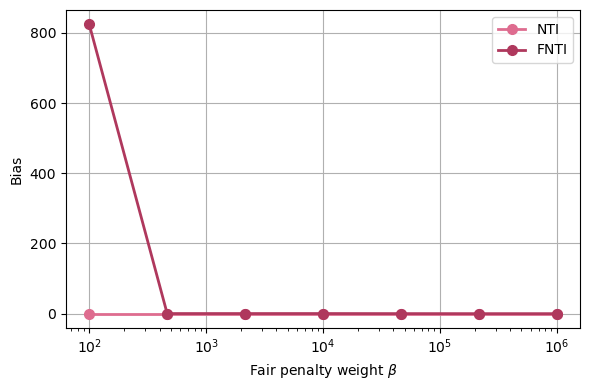

In [4]:
# --------------------------------
verbose = True
num_trials = 20
num_range = 7

opt_bias_type = 'groupwise'
eval_bias_type = 'groupwise'
REWEIGHTED = False
UPPER_BOUND = False
norm_scale = lambda A: np.sum(A[0])

beta_range = np.logspace(1,5,num_range)*1e1
num_range = len(beta_range)
# --------------------------------


# --------------------------------
X = np.array(votes_list).T
z = nodes[0]
G = len(np.unique(z))
Z = np.eye(G)[z].T
N = X.shape[1]
M = X.shape[0]

X = (X.T - np.mean(X, axis=1)) / np.std(X, axis=1);

C_est = est_cov(X=X.T)
# --------------------------------


# --------------------------------
alpha = 1
beta = 100e3
delta = 1e-4
eps_thresh = 1e-2

gsr_args = {
    'C':C_est,
    'alpha':alpha
}
fgsr_args = {
    'C':C_est,
    'Z':Z,
    'alpha':alpha,
    'beta':beta,
    'bias_type':opt_bias_type
}

mu = 1e2
eps_init = 1e-2
factor_eps = 1.5
max_iters_eps = 25
if UPPER_BOUND:
    gsr_args = gsr_args | {'eps':eps_init}
    fgsr_args = fgsr_args | {'eps':eps_init}
else:
    gsr_args = gsr_args | {'mu':mu}
    fgsr_args = fgsr_args | {'mu':mu}

rw_args = {
    'delta':delta,
    'eps_thresh':eps_thresh,
    'verbose':False
}
if REWEIGHTED:
    gsr_args = gsr_args | rw_args
    fgsr_args = fgsr_args | rw_args

EstGraph = GSR if not REWEIGHTED else GSR_reweighted
EstFGraph = FGSR if not REWEIGHTED else FGSR_reweighted
EstFGraph = FGLASSO
# --------------------------------


# --------------------------------
bias_nti = np.zeros(num_range)
bias_fnti = np.zeros(num_range)
# --------------------------------


# --------------------------------
for i,beta in enumerate(beta_range):
    if verbose:
        print(f'Beta: {beta:.4e}')
    fgsr_args['beta'] = beta


    # --------------------------------
    if UPPER_BOUND:
        gsr_args['eps'] = eps_init
        fgsr_args['eps'] = eps_init
        for i_eps in range(max_iters_eps):
            A_nti = EstGraph(**gsr_args)
            A_fnti = EstFGraph(**fgsr_args)
            if (A_nti is not None) and (A_fnti is not None):
                break
            gsr_args['eps'] *= factor_eps
            fgsr_args['eps'] *= factor_eps
    else:
        A_nti = EstGraph(**gsr_args)
        A_fnti = EstFGraph(**fgsr_args)
    if (A_nti is None) or (A_fnti is None):
        print(f'Problem did not converge. Proceed with caution.')
    A_norm_nti = A_nti/norm_scale(A_nti) if norm_scale(A_nti) else np.zeros_like(A_nti)
    A_norm_fnti = A_fnti/norm_scale(A_fnti) if norm_scale(A_fnti) else np.zeros_like(A_fnti)
    # --------------------------------


    # --------------------------------
    bias_nti[i] = compute_bias(A_norm_nti,Z,bias_type=eval_bias_type)
    bias_fnti[i] = compute_bias(A_norm_fnti,Z,bias_type=eval_bias_type)
    # --------------------------------
# --------------------------------


# --------------------------------
plt_args = {
    'linestyle':'-',
    'marker':'o',
    'markersize':7,
    'linewidth':2
}
# --------------------------------


# --------------------------------
# Bias
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
ax.grid(True)
plt_args['c'] = reds[8]
ax.semilogx(beta_range, bias_nti, **plt_args, label='NTI')
plt_args['c'] = reds[14]
ax.semilogx(beta_range, bias_fnti, **plt_args, label='FNTI')

ax.set_xlabel('Fair penalty weight '+r'$\beta$')
ax.set_ylabel('Bias')
ax.legend()
fig.tight_layout()
# --------------------------------

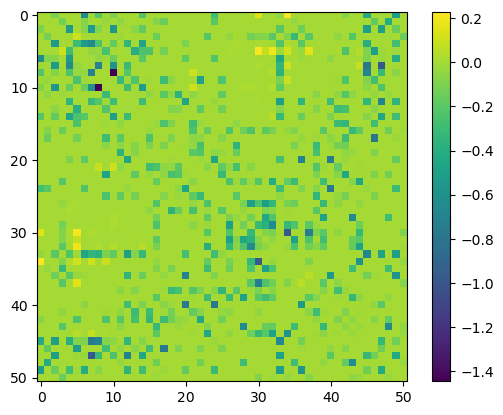

In [11]:
fgsr_args['beta'] = 1e2
fgsr_args['alpha'] = 1e-1
# --------------------------------
if UPPER_BOUND:
    gsr_args['eps'] = eps_init
    fgsr_args['eps'] = eps_init
    for i_eps in range(max_iters_eps):
        A_nti = EstGraph(**gsr_args)
        A_fnti = EstFGraph(**fgsr_args)
        if (A_nti is not None) and (A_fnti is not None):
            break
        gsr_args['eps'] *= factor_eps
        fgsr_args['eps'] *= factor_eps
else:
    A_nti = EstGraph(**gsr_args)
    A_fnti = EstFGraph(**fgsr_args)
if (A_nti is None) or (A_fnti is None):
    print(f'Problem did not converge. Proceed with caution.')
A_norm_nti = A_nti/norm_scale(A_nti) if norm_scale(A_nti) else np.zeros_like(A_nti)
A_norm_fnti = A_fnti/norm_scale(A_fnti) if norm_scale(A_fnti) else np.zeros_like(A_fnti)
# --------------------------------


np.fill_diagonal(A_fnti,0)
plt.imshow(A_fnti)
plt.colorbar()


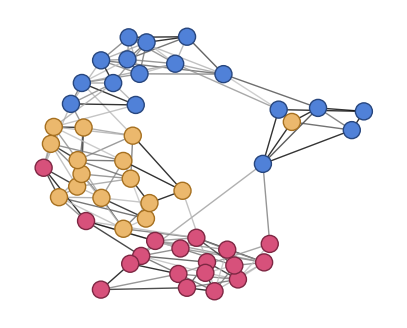

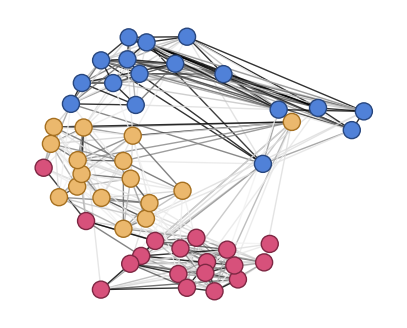

In [14]:
from matplotlib import colormaps
import networkx as nx

pos = nx.spring_layout(nx.Graph(A_nti))
party_colors = [blues[10],reds[10],yellows[6]]
party_edge_colors = [blues[18],reds[18],yellows[16]]
clr_list = [party_colors[z[i]] for i in range(len(z))]
edge_list = [party_edge_colors[z[i]] for i in range(len(z))]
cmap = colormaps['Greys']

eps_thresh = 1e-3
eps_thresh = 1e-2
eps_thresh = 5e-2
A_nti_pred = np.abs(A_nti)
A_nti_pred[A_nti_pred <= eps_thresh] = 0
A_fnti_pred = np.abs(A_fnti)
A_fnti_pred[A_fnti_pred <= eps_thresh] = 0

# --------------------------------
edge_color = [edgedata['weight'] for _, _, edgedata in nx.Graph(A_nti_pred).edges(data=True)]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
ax.axis('off')
nx.draw_networkx_edges(nx.Graph(A_nti_pred), 
                       alpha=.8,
                       pos=pos, width=1,
                       edge_color=edge_color,
                       edge_cmap=cmap, 
                       edge_vmin=A_nti_pred.max()*0, 
                       edge_vmax=A_nti_pred.max()*.3
                       )
nx.draw_networkx_nodes(nx.Graph(A_nti_pred), 
                       pos=pos, node_size=150, linewidths=1,
                       node_color=clr_list,
                       edgecolors=edge_list)


edge_color = [edgedata['weight'] for _, _, edgedata in nx.Graph(A_fnti_pred).edges(data=True)]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
ax.axis('off')
nx.draw_networkx_edges(nx.Graph(A_fnti_pred), 
                       alpha=.8,
                       pos=pos, width=1, 
                       edge_color=edge_color,
                       edge_cmap=cmap, 
                       edge_vmin=A_fnti_pred.max()*0, 
                       edge_vmax=A_fnti_pred.max()*.3
                       )
nx.draw_networkx_nodes(nx.Graph(A_fnti_pred), 
                       pos=pos, node_size=150, linewidths=1,
                       node_color=clr_list,
                       edgecolors=edge_list)
# --------------------------------


In [8]:
# 1 is yea, 6 is nay, 9/7 is abstain?